# Imports
Import libraries and write settings here.

In [3]:
# Notebooks specific imports ########################################
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm
# End notebooks specific imports ####################################

# Basic useful imports
import yaml
from pathlib import Path
import h5py

# Data manipulation
import numpy as np

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

# From alens_analysis
import alens_analysis as aa
import alens_analysis.chromatin as aac

# Locations
alens_data_path = Path.home() / 'projects/DATA/my_alens_data_new/'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)
        

Let's read in the data and take a first look at the motion of the moving sylinder over time.

1002


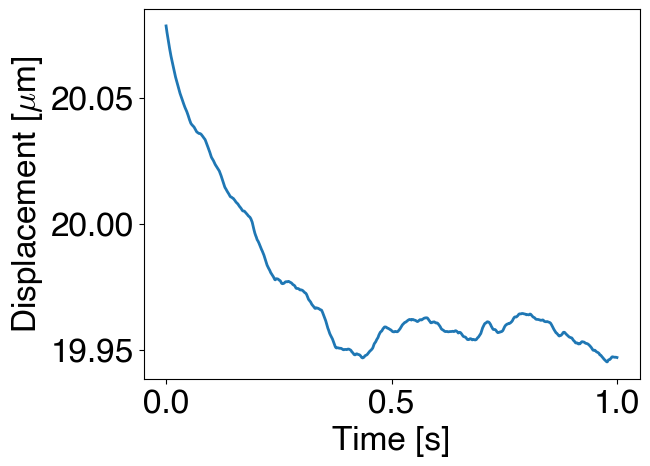

In [6]:
# Set the root of your simulation data. Pathlib makes extending the data paths easy.
sim_path = alens_data_path / 'MixMotorSliding'

# Load in collected data from simulation, 'with' statement automatically closes file when done
with h5py.File(next(sim_path.glob('analysis/raw_MixMotorSliding.h5')), 'r+') as h5_data:
    # Load in time of every data point
    time_arr = h5_data['time'][:] # [:] loads data as numpy array
    print(time_arr.size) # How many time points are there?
    # Load in sylinder data and get center of mass (COM) locations
    sy_dat = h5_data['raw_data']['sylinders'][...]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

# Plot total displacement of COM of rod 1 vs time
_ = plt.plot(time_arr, np.linalg.norm(sy_dat[1,:,:],axis=0))
_ = plt.xlabel("Time [s]")
_ = plt.ylabel("Displacement [$\mu$m]")

The overall structure of the HDF5 file can be visualized by using the `.visit()` method of the `h5py.File` object. This method takes a function as an argument and applies it to every group and dataset in the file. The function below prints the name of the group or dataset.

In [29]:
with h5py.File(next(sim_path.glob('analysis/raw_MixMotorSliding.h5')), 'r+') as h5_data:
    h5_data.visit(print) # Print all groups and datasets in file

raw_data
raw_data/proteins
raw_data/sylinders
time


`raw_data` is a group that contains both data from 'sylinders' and 'proteins' recorded in the ascii files of the _aLENS_.

## Accessing parameters from the raw HDF5 file

If we want to inspect the parameters of the simulations, we can do that by reading in the yaml file stored in HDF5 file attrs

In [7]:
with h5py.File(next(sim_path.glob('analysis/raw_MixMotorSliding.h5')), 'r+') as h5_data:
    # Print what data is stored in the attribute dictionary of h5_data
    print(h5_data.attrs.keys(), "\n")
    # Examine the RunConfig file
    print( "###### RunConfig file string ########")
    run_config_str = h5_data.attrs['RunConfig']
    print(run_config_str, "\n")



<KeysViewHDF5 ['ProteinConfig', 'RunConfig']> 

###### RunConfig file string ########
KBT: -0.00411
conMaxIte: 10000
conResTol: 1e-5
conSolverChoice: 0
dt: 1.0e-05
logLevel: 3
monolayer: false
rngSeed: 1234
simBoxHigh:
- 20.0
- 1.0
- 1.0
simBoxLow:
- 0.0
- 0.0
- 0.0
simBoxPBC:
- false
- false
- false
sylinderColBuf: 0.025
sylinderDiameter: 0.025
sylinderDiameterColRatio: 1.0
sylinderFixed: false
sylinderLength: 0.5
sylinderLengthColRatio: 1.0
sylinderLengthSigma: 0
sylinderNumber: 4000
timeSnap: 0.001
timeTotal: 1.0
timerLevel: 3
viscosity: 1.0
 



To make this more usable we can convert the yaml file string to a python dictionary. This is useful for example if we want to use the parameters in a plot or in analysis e.g. rescaling by temperature, viscosity, etc.

In [8]:
print( "###### RunConfig dictionary ########")
# Load in the yaml dictionary
param_dict = yaml.load(run_config_str, Loader=yaml.FullLoader)  
print(param_dict, "\n")
print(" The viscosity of the fluid is", param_dict['viscosity'], "pN s/um^2")

###### RunConfig dictionary ########
{'KBT': -0.00411, 'conMaxIte': 10000, 'conResTol': '1e-5', 'conSolverChoice': 0, 'dt': 1e-05, 'logLevel': 3, 'monolayer': False, 'rngSeed': 1234, 'simBoxHigh': [20.0, 1.0, 1.0], 'simBoxLow': [0.0, 0.0, 0.0], 'simBoxPBC': [False, False, False], 'sylinderColBuf': 0.025, 'sylinderDiameter': 0.025, 'sylinderDiameterColRatio': 1.0, 'sylinderFixed': False, 'sylinderLength': 0.5, 'sylinderLengthColRatio': 1.0, 'sylinderLengthSigma': 0, 'sylinderNumber': 4000, 'timeSnap': 0.001, 'timeTotal': 1.0, 'timerLevel': 3, 'viscosity': 1.0} 

 The viscosity of the fluid is 1.0 pN s/um^2


We can also collect data without command line interface by using the `convert_dat_to_hdf` function provided in alens_analysis. Let's try this on our newly created data.

In [10]:
opts = lambda: None # Create an empty object to store analysis options
opts.path = alens_data_path / 'MixMotorSliding'
opts.analysis = 'collect' # This replicates the -A flag when running `analens -A collect`
opts.analysis_dir = opts.path / 'analysis' # Specify where to store the analysis files
opts.analysis_dir.mkdir(exist_ok=True) # Make sure the analysis directory exists

aa.seed_analysis(opts)


raw_MixMotorSliding
Made time data set in 0.0722968578338623 seconds.
Made sylinder data set in 0.3379371166229248 seconds.
Made protin data set in 1.1798269748687744 seconds.
Made raw data file in a total of 1.590503215789795 seconds.
 HDF5 raw created in 1.6778228282928467


## Post-processing of data

Sometimes analyzing your data can take a long time and you would like to save that analysis for easy graphing later. So let's look at the more complicated system the we ran at the beginning of this tutorial in `Active3DNematic`. First we generate the raw data file previously,  

In [11]:
opts = lambda: None 
opts.path = alens_data_path / 'Active3DNematic' # Notice the different path
opts.analysis = 'collect'
opts.analysis_dir = opts.path / 'analysis'
opts.analysis_dir.mkdir(exist_ok=True)

aa.seed_analysis(opts)


raw_Active3DNematic
Made time data set in 1.2163310050964355 seconds.
Made sylinder data set in 8.403854846954346 seconds.
Made protin data set in 14.316713094711304 seconds.
Made raw data file in a total of 23.93737006187439 seconds.
 HDF5 raw created in 24.07668900489807


Now we wish to calculate how aligned all the filaments are over time. This is known as the nematic order and is the largest eigenvalue from the nematic order tensor 
$$Q_{\alpha\beta} = \frac{1}{N}\sum_{i=1}^N \left( \frac{3}{2} \hat{u}_{i\alpha}\hat{u}_{i\beta} - \frac{1}{d}\delta_{\alpha\beta} \right)$$
where $\hat{u}_i$ is the unit vector along the filament $i$, $N$ is the number of filaments, and $d\in \{2,3\}$ is the number of spatial dimension of the system. aLENS analysis provides a function `calc_nematic_order` function to do just this.
However, because we are in a periodic box and _aLENS_ only keeps track of the tips of the filaments, we need to correct data for the periodic boundary conditions.  Luckily, aLENS analysis also provides the function `apply_pbc_to_raw_syl_data` in the helpers moduls. This function takes in the raw data and the parameters of the simulation and returns the corrected data. 

In [18]:
import alens_analysis.chromatin.make_motion_graph as mmg

with h5py.File(next(opts.analysis_dir.glob('raw*.h5')), 'r') as h5_data:
    param_dict = yaml.load(h5_data.attrs['RunConfig'], Loader=yaml.FullLoader)  
    protein_dict = yaml.load(h5_data.attrs['ProteinConfig'], Loader=yaml.FullLoader)  
    box_lower = np.array(param_dict['simBoxLow'])
    box_upper = np.array(param_dict['simBoxHigh'])
    time_arr = h5_data['time'][:] # Load in time array, [:] loads data as numpy array
    # Load in sylinder data
    sy_dat = h5_data['raw_data/sylinders'][...]
    # aLENS analysis has some useful helper functions for post-processing data
    # This function applies periodic boundary conditions to the raw sylinder data.
    sy_dat = aa.helpers.apply_pbc_to_raw_syl_data(sy_dat, box_lower, box_upper)
    print(sy_dat.shape)

    

(500, 9, 1002)


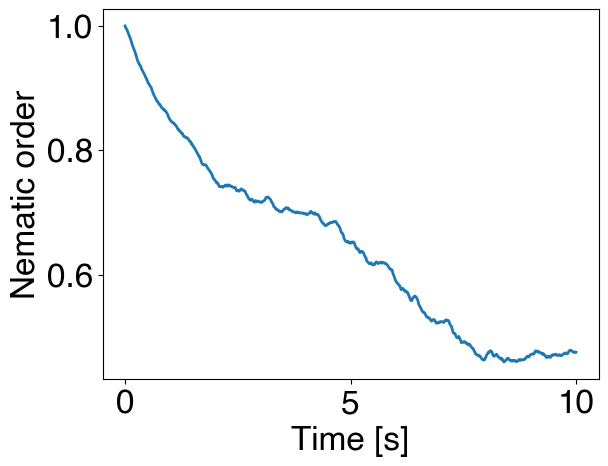

In [19]:
nematic_order = aa.nematic_order.calc_nematic_order(sy_dat)
_ = plt.plot(time_arr, nematic_order)
_ = plt.xlabel("Time [s]")
_ = plt.ylabel("Nematic order")

# Saving post-processed data with HDF5

While the above calculation happened quickly, it is possible that the analysis you want to do takes a long time. In this case, you can save the data to a file for later use. Let's save the nematic order data we just calculated.

In [23]:
# Open an hdf5 file for writing, (w = write, will overwrite existing files)
with h5py.File(opts.analysis_dir / 'nematic_order.h5', 'w') as h5_data:
    # Save the RunConfig string to the attributes for easy access later
    h5_data.attrs['RunConfig'] = yaml.dump(param_dict)
    h5_data.attrs['ProteinConfig'] = yaml.dump(protein_dict)
    # Save the time array
    _ = h5_data.create_dataset('time', data=time_arr)
    # Save the nematic order array
    _ = h5_data.create_dataset('nematic_order', data=nematic_order)

Let's read in the data and see if we get the same thing as before.

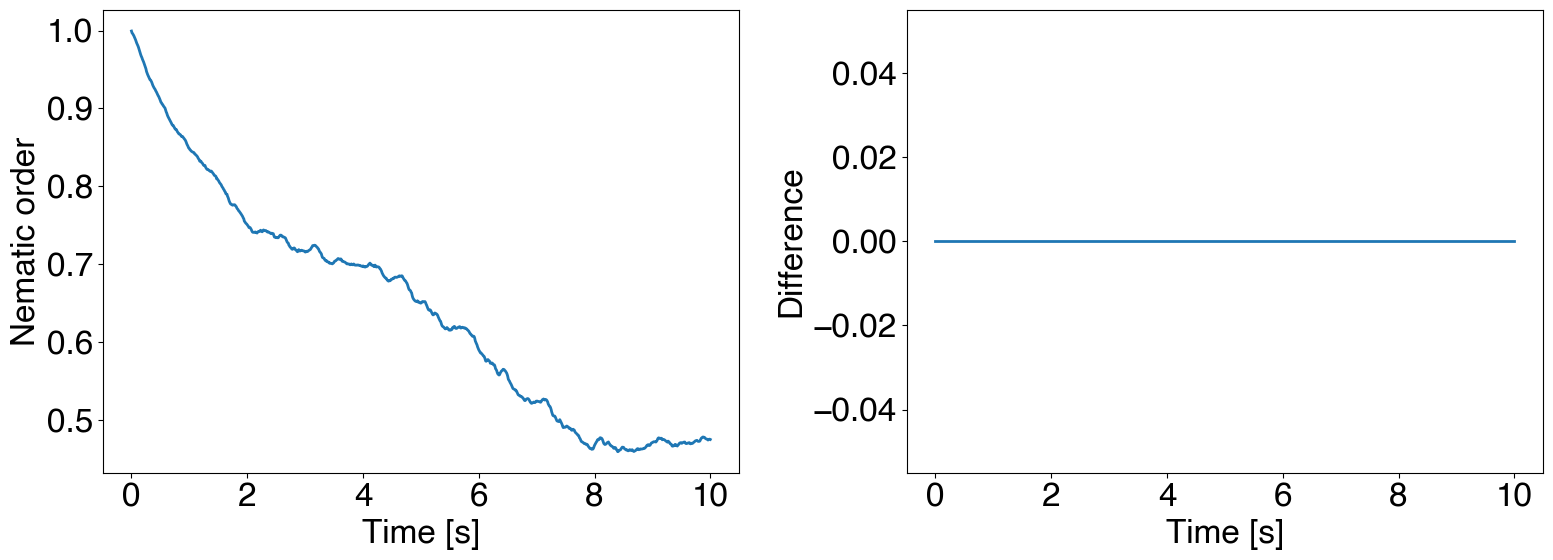

In [28]:
with h5py.File(opts.analysis_dir / 'nematic_order.h5', 'r') as h5_data:
    time_arr = h5_data['time'][:] # Load in time array, [:] loads data as numpy array
    # Load nematic data
    new_nematic_order = h5_data['nematic_order'][:]

# Plot the nematic order parameter
fig, axarr = plt.subplots(1,2, figsize=(16, 6))

_ = axarr[0].plot(time_arr, new_nematic_order)
_ = axarr[0].set_xlabel("Time [s]")
_ = axarr[0].set_ylabel("Nematic order")

_ = axarr[1].plot(time_arr, nematic_order - new_nematic_order)
_ = axarr[1].set_xlabel("Time [s]")
_ = axarr[1].set_ylabel("Difference")
fig.tight_layout()  

Notice how much faster that was then calculating the nematic order again. This is especially useful if you want to plot the data in different ways or if you want to compare the data from different simulations.

If you perform another analysis and would like to include it in the same file, you can add it using the `mode='r+'`(read and append) or `mode='a'`(append). You can still overwrite data already in the hdf5 file if the same dataset name exists, so be careful. It is often wiser to make another file if you are unsure.

In [31]:
# Open an hdf5 file and show tree structure
with h5py.File(opts.analysis_dir / 'nematic_order.h5', 'r+') as h5_data:
    print("## Previous data structure ##")
    h5_data.visit(print) # Print the tree structure of the hdf5 file

    new_grp = h5_data.create_group('new_group') # Create a new group
    new_grp.create_dataset('new_dataset', data=np.arange(10)) # Create a new dataset

    print("## Post modifications of data structure ##")
    h5_data.visit(print) # Print the tree structure of the hdf5 file


## Previous data structure ##
nematic_order
time


<HDF5 dataset "new_dataset": shape (10,), type "<i8">

## Post modifications of data structure ##
nematic_order
new_group
new_group/new_group
new_group/new_group/new_dataset
time
